# Deep Learning

### DL imports

In [1]:
# just to make sure that all libraries are available
%pip install tensorflow matplotlib pandas folium kaggle scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Misc. Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import math
import string

## Get data from Kaggle

In [4]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

401 - Unauthorized


In [6]:
!mkdir yelp-data
!unzip -d yelp-data yelp-dataset.zip

mkdir: yelp-data: File exists
Archive:  yelp-dataset.zip
replace yelp-data/Dataset_User_Agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Examine and plot it

In [7]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
target_file = "yelp_academic_dataset_review.json"

In [8]:
data_file = data_dir + target_file

In [9]:
def read_to_dataframe(data_file, max_nl = 100_000):
  data = []
  with open(data_file) as f:
    nl = 0
  
    for line in f:
      data.append(json.loads(line))
    
      nl += 1
      if nl >= max_nl:
        break

  return pd.DataFrame(data)

In [10]:
data_df = read_to_dataframe(data_file)

In [11]:
data_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [12]:
data_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB


In [13]:
data_df.describe()

,stars,useful,funny,cool
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.842910,0.898980,0.257180,0.347030
std,1.354729,2.205186,1.010212,1.066382
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,98.000000,49.000000


I don't particularly like the identifiers used in this dataframe, so I'll join this data with the data containing additional information about them so that we get much more meaningful and human-friendly data.

In [15]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file, max_nl=math.inf) # no need to set a limit (the file is 113MB large)
business_df.drop(["stars"], axis=1, inplace=True) # this is the rating of the businesses (we don't care about that)

In [16]:
rich_data = pd.merge(data_df, business_df, on="business_id")

In [17]:
rich_data.head() # as we can see, we now have a richer dataset, which makes it easier to identify the businesses (as far as the reviews and the users are concerned, it's not important to further enrich the data)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,...,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


For a much cooler visualization, we can use the folium library!

In [ ]:
import folium

fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_data.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)
# Iterate over your dataset and add markers for each data point
for index, row in sampled_df.iterrows():
    # Extract the latitude and longtude values from your dataframe
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Add a marker to the map for each data point
    folium.Marker([latitude, longitude]).add_to(map_obj)

# Display the map
map_obj

## Prepare the data 

In [120]:
# Load your dataset into a pandas DataFrame (assuming 'df' is your DataFrame)
# Split the dataset into features (X) and labels (y)
X = rich_data['text']
y = rich_data['stars']

# Split the dataset into training (70%), validation (15%), and testing (15%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (69997,) (69997,)
Validation set shape: (15003,) (15003,)
Testing set shape: (15000,) (15000,)


In [121]:
# need to do some padding...
def get_max_review_length(dataframe, column_name):
    max_length = 0
    for review in dataframe[column_name]:
        length = len(review.split())
        if length > max_length:
            max_length = length
    return max_length

max_length = get_max_review_length(rich_data, "text")

In [122]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization = layers.TextVectorization(
    max_tokens=30_000,
    output_mode='multi_hot',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    # the option below is only useful if output_mode is "int" (it takes care of the padding)
    # output_sequence_length=max_length,
)

In [123]:
# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [124]:
text_vectorization.adapt(train_dataset.map(lambda review, label: review)) # build the vocabulary (might take a while...)

In [125]:
# Define the preprocessing pipeline for the datasets
def preprocess(review, label):
    vectorized_review = text_vectorization(review)
    return vectorized_review, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(lambda review, label: (text_vectorization(review), label))
val_dataset = val_dataset.map(lambda review, label: (text_vectorization(review), label))
test_dataset = test_dataset.map(lambda review, label: (text_vectorization(review), label))

# Shuffle and batch the training dataset
batch_size = 64  # Adjust this value based on your requirements
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)

# Batch the validation and testing datasets
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Let's take a look at the data!

In [126]:
for inputs, targets in train_dataset:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-06-08 19:02:27.899225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44716 of 69997


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(5.0, shape=(), dtype=float64)


2023-06-08 19:02:33.537664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


## Find correct architecture

Let's try a simple 1-gram bag-of-words model first:

In [127]:
def create_model(input_dim):
    input = tf.keras.Input(shape=(input_dim,))

    x = layers.Dense(256, activation='relu')(input)  # Dense layer with 32 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(256, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(128, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5
    x = layers.Dense(64, activation='relu')(x)  # Dense layer with 16 neurons
    x = layers.Dropout(0.5)(x)  # Dropout layer with rate 0.5

    output = layers.Dense(1)(x)  # Output layer with a single neuron (regression)

    model = tf.keras.Model(inputs=input, outputs=output)

    optimizer = keras.optimizers.legacy.Adam(learning_rate=0.01)
    # Compile the model with mean squared error (MSE) loss for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [128]:
model = create_model(len(text_vectorization.get_vocabulary()))

In [129]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 30000)]           0         
                                                                 
 dense_48 (Dense)            (None, 256)               7680256   
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)               32896     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0  

In [130]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


2023-06-08 19:02:45.467360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43682 of 69997


   9/1094 [..............................] - ETA: 17s - loss: 14.8724 - mse: 14.8724 - accuracy: 0.0208       

2023-06-08 19:02:51.360370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 1.9316 - mse: 1.9316 - accuracy: 0.1083 - val_loss: 0.6922 - val_mse: 0.6922 - val_accuracy: 0.1092
Epoch 2/10


2023-06-08 19:03:22.892685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45088 of 69997


  12/1094 [..............................] - ETA: 17s - loss: 1.0134 - mse: 1.0134 - accuracy: 0.1042  

2023-06-08 19:03:28.478367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 1.0365 - mse: 1.0365 - accuracy: 0.1087 - val_loss: 0.5755 - val_mse: 0.5755 - val_accuracy: 0.1092
Epoch 3/10


2023-06-08 19:03:59.671306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45396 of 69997


   9/1094 [..............................] - ETA: 17s - loss: 0.8347 - mse: 0.8347 - accuracy: 0.1059   

2023-06-08 19:04:05.168837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.8670 - mse: 0.8670 - accuracy: 0.1087 - val_loss: 0.6377 - val_mse: 0.6377 - val_accuracy: 0.1092
Epoch 4/10


2023-06-08 19:04:36.320117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45092 of 69997


   9/1094 [..............................] - ETA: 17s - loss: 0.7557 - mse: 0.7557 - accuracy: 0.1024   

2023-06-08 19:04:41.933086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.7285 - mse: 0.7285 - accuracy: 0.1089 - val_loss: 0.5163 - val_mse: 0.5163 - val_accuracy: 0.1092
Epoch 5/10


2023-06-08 19:05:13.090815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45144 of 69997


   9/1094 [..............................] - ETA: 16s - loss: 0.6149 - mse: 0.6149 - accuracy: 0.1042   

2023-06-08 19:05:18.649278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.6271 - mse: 0.6271 - accuracy: 0.1082 - val_loss: 0.5322 - val_mse: 0.5322 - val_accuracy: 0.1092
Epoch 6/10


2023-06-08 19:05:49.928181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44965 of 69997


  12/1094 [..............................] - ETA: 17s - loss: 0.5875 - mse: 0.5875 - accuracy: 0.1146  

2023-06-08 19:05:55.601611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.5603 - mse: 0.5603 - accuracy: 0.1070 - val_loss: 0.5351 - val_mse: 0.5351 - val_accuracy: 0.1092
Epoch 7/10


2023-06-08 19:06:26.890537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45047 of 69997


   8/1094 [..............................] - ETA: 18s - loss: 0.6078 - mse: 0.6078 - accuracy: 0.1152   

2023-06-08 19:06:32.491920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 20ms/step - loss: 0.5135 - mse: 0.5135 - accuracy: 0.1063 - val_loss: 0.5506 - val_mse: 0.5506 - val_accuracy: 0.1092
Epoch 8/10


2023-06-08 19:07:03.849291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45011 of 69997


  11/1094 [..............................] - ETA: 17s - loss: 0.4567 - mse: 0.4567 - accuracy: 0.1023  

2023-06-08 19:07:09.466923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 20ms/step - loss: 0.4690 - mse: 0.4690 - accuracy: 0.1058 - val_loss: 0.5338 - val_mse: 0.5338 - val_accuracy: 0.1092
Epoch 9/10


2023-06-08 19:07:40.984000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45240 of 69997


   7/1094 [..............................] - ETA: 19s - loss: 0.4622 - mse: 0.4622 - accuracy: 0.1004   

2023-06-08 19:07:46.522199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.4477 - mse: 0.4477 - accuracy: 0.1054 - val_loss: 0.5707 - val_mse: 0.5707 - val_accuracy: 0.1092
Epoch 10/10


2023-06-08 19:08:17.697207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45339 of 69997


  11/1094 [..............................] - ETA: 18s - loss: 0.3943 - mse: 0.3943 - accuracy: 0.0938  

2023-06-08 19:08:23.359822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 20ms/step - loss: 0.4241 - mse: 0.4241 - accuracy: 0.1052 - val_loss: 0.5785 - val_mse: 0.5785 - val_accuracy: 0.1092


In [131]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    # Plot loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

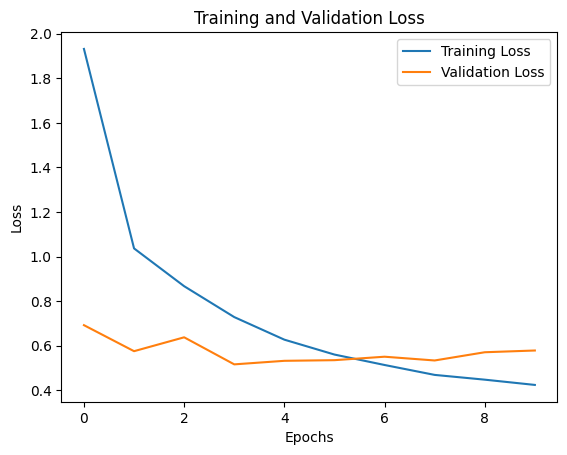

In [132]:
plot_training_curves(history)